# Benchmarking models from the [BioImage Model Zoo](https://bioimage.io/#/) using [BioImage Archive](https://www.ebi.ac.uk/bioimage-archive/) data

## Setup

### Google Colab

In [ ]:
!pip install --quiet zarr
!pip install --quiet bioimageio.core==0.6.9
!pip install --quiet dask

### Import necessary dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import zarr
import dask.array as da
import numpy as np
import bioimageio.core
from bioimageio.core import Tensor, Sample, create_prediction_pipeline
from bioimageio.spec.utils import load_array

### Helper methods

In [ ]:
# Function to load a zarr file as a dask array
def remote_zarr_to_model_input(ome_zarr_uri):
    
    zgroup = zarr.open(ome_zarr_uri)
    zarray = zgroup['0']    

    darray = da.from_zarr(zarray)

    return darray

# Function to handle model inference
def run_model_inference(bmz_model, arr):
    # load model
    model_resource = bioimageio.core.load_description(bmz_model)

    test_input_image = load_array(model_resource.inputs[0].test_tensor)

    # match test data type with the data type of the model input
    arr = arr.astype(test_input_image.dtype)

    # reshape data to match model input dimensions
    indices = [i for i in range(len(test_input_image.shape)) if test_input_image.shape[i] == 1]
    right_dims = np.expand_dims(arr, indices)
    input_tensor = Tensor.from_numpy(right_dims, dims=tuple(model_resource.inputs[0].axes))

    # Create collection of tensors (sample)
    inp_id = model_resource.inputs[0].id
    outp_id = model_resource.outputs[0].id
    sample = Sample(members={inp_id: input_tensor}, stat={}, id="id")

    prediction_pipeline = create_prediction_pipeline(model_resource)
    prediction = prediction_pipeline.predict_sample_without_blocking(sample) 

    return prediction, sample, inp_id, outp_id


![Benchmarking info](images/benchmarking_metrics_info.png)

Function to compute benchmarking scores

In [25]:
def benchmarking_scores(pred_mask, groundtruth_mask):
    true_positives = np.sum(pred_mask*groundtruth_mask)
    true_false_postives = np.sum(pred_mask)
    precision = np.mean(true_positives/true_false_postives)
    print(f"Precision score: {round(precision, 3)}")

    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(true_positives/total_pixel_truth)
    print(f"Recall score: {round(recall, 3)}")

### Select model from the BioImage Model Zoo

The BioImage Model Zoo models may be identified via their bioimage.io __ID__, e.g. "affable-shark" or the [__DOI__](https://doi.org/) of their [__Zenodo__](https://zenodo.org/) backup. We will work with ["affable-shark"](https://bioimage.io/#/?tags=affable-shark&id=10.5281%2Fzenodo.5764892), a model for 2D nuclear segmentation.

In [5]:
bmz_model_id =  "affable-shark"
bmz_model_doi =  "10.5281/zenodo.5764892"

### Select and load dataset from the BIA

We will use [S-BIAD634](https://www.ebi.ac.uk/biostudies/bioimages/studies/S-BIAD634) a dataset that has ground truth annotations for this particular task. It contains images and ground truth segmentation masks for human cell nuclei, from cell lines and cancer tissues.

In [6]:
image_uri1 = 'https://uk1s3.embassy.ebi.ac.uk/bia-zarr-test/normal_26.ome.zarr/0'
annotation_uri1 = 'https://uk1s3.embassy.ebi.ac.uk/bia-zarr-test/normal_26_mask.ome.zarr/0'

 Load image and annotation as dask arrays

In [7]:
image_array1 = remote_zarr_to_model_input(image_uri1)
annotation_array1 = remote_zarr_to_model_input(annotation_uri1)

Let's look at the dimensionality of these arrays. Note that the dimension order of OME-Zarr images is: (Time, Channel, Z, Y, X)

In [8]:
print(f"input image shape: {image_array1.shape}")
print(f"input annotation shape: {annotation_array1.shape}")

input image shape: (1, 1, 1, 1024, 1280)
input annotation shape: (1, 1, 1, 1024, 1280)


These are 2D images with only one channel

### Run model inference

In [9]:
full_image_array = image_array1.compute()
prediction, sample, inp_id, outp_id = run_model_inference(bmz_model_id, full_image_array)

2025-03-22 15:10:19.904 | INFO     | bioimageio.spec._internal.io_utils:open_bioimageio_yaml:112 - loading affable-shark from https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/1.1/files/rdf.yaml
computing SHA256 of 3c123c5162a87c48333c80f7389e99a7-zero_mean_unit_variance.ijm (result: 767f2c3a50e36365c30b9e46e57fcf82e606d337e8a48d4a2440dc512813d186): 100%|██████████| 1/1 [00:00<00:00, 587.60it/s] 
computing SHA256 of 93e503596d7d0bbf5b3937cf1a80402b-test_input_0.npy (result: c29bd6e16e3f7856217b407ba948222b1c2a0da41922a0f79297e25588614fe2): 100%|██████████| 3/3 [00:00<00:00, 1293.07it/s]
computing SHA256 of baeb9b3639733aa6ad5f8305149a3585-sample_input_0.tif (result: a24b3c708b6ca6825494eb7c5a4d221335fb3eef5eb9d03f4108907cdaad2bf9): 100%|██████████| 1/1 [00:00<00:00, 378.24it/s]
computing SHA256 of 858a63339bdb8f80ff310e077a5079bb-test_output_0.npy (result: 510181f38930e59e4fd8ecc03d6ea7c980eb6609759655f2d4a41fe36108d5f5): 100%|██████████| 5/5 [00:00<00:00, 1630.

### Explore and plot the results

We need to convert the prediction tensor into an array

In [10]:
pred_array1 = np.asarray(prediction.members[outp_id].data)
print(f"prediction shape: {pred_array1.shape}")

prediction shape: (1, 2, 1024, 1280)


Note that there are two different outputs from the model! Let's look at them

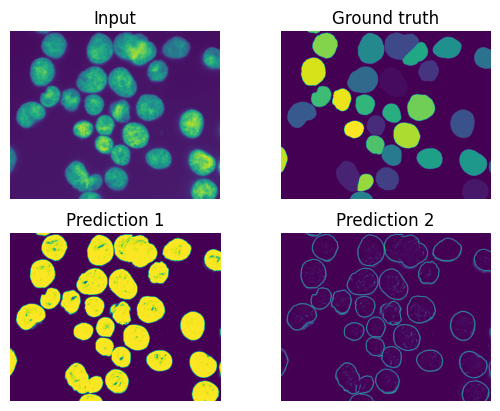

In [29]:
ax1 = plt.subplot(2, 2, 1)
ax1.set_title("Input")
ax1.axis("off")
plt.imshow(image_array1[0, 0, 0, :, :])

ax1 = plt.subplot(2, 2, 2)
ax1.set_title("Ground truth")
ax1.axis("off")
plt.imshow(annotation_array1[0, 0, 0, :, :])

ax2 = plt.subplot(2, 2, 3)
ax2.set_title("Prediction 1")
ax2.axis("off")
plt.imshow(pred_array1[0, 0, :, :])

ax2 = plt.subplot(2, 2, 4)
ax2.set_title("Prediction 2")
ax2.axis("off")
plt.imshow(pred_array1[0, 1, :, :])

### Run benchmarking

We will benchmark the first output, as it is the one for wich we have ground truth. First we need to binarise the prediction and ground truth. Note that the prediction is floating point data that shows a probability from 0 to 1. While the ground truth annotation is an unsigned integer.

In [12]:
print(f"prediction data type: {pred_array1.dtype}")
print(f"ground truth data type: {annotation_array1.dtype}")

prediction data type: float32
ground truth data type: >u2


We will binarise the prediction by selecting only pixels that are above 0.5. Integer data can be binarised simply by converting it to a boolean type that stores the values True and False.

In [13]:
binary_pred1 = pred_array1[0, 0, :, :] >= 0.5
annotation_array1 = np.asarray(annotation_array1)
binary_gt1 = annotation_array1.astype(bool)

Now let's look at the benchmarking results

In [26]:
scores_image1 = benchmarking_scores(binary_pred1, binary_gt1)

Precision score: 0.972
Recall score: 0.988


### Let's test the model with another image!

We will use [S-BIAD1518](https://www.ebi.ac.uk/biostudies/bioimages/studies/S-BIAD1518) a study that contains several datasets with ground truth segmentation masks. We will focus on an image of cell nuclei in rat kidney.

In [15]:
image_uri2 = 'https://uk1s3.embassy.ebi.ac.uk/bia-zarr-test/Scale-cleared_rat_kidney_1_192-192-48.zarr/0'
annotation_uri2 = 'https://uk1s3.embassy.ebi.ac.uk/bia-zarr-test/Scale-cleared_rat_kidney_1_192-192-48_gt.zarr/0'

In [16]:
image_array2 = remote_zarr_to_model_input(image_uri2)
annotation_array2 = remote_zarr_to_model_input(annotation_uri2)

Let's look at the dimensionality of these arrays. Note that the dimension order of OME-Zarr images is: (Time, Channel, Z, Y, X)

In [17]:
print(f"input image shape: {image_array2.shape}")
print(f"input annotation shape: {annotation_array2.shape}")

input image shape: (1, 1, 64, 128, 128)
input annotation shape: (1, 1, 64, 128, 128)


These are 3D images with multiple z planes. Because the model is for 2D images we need to select  a z plane

In [18]:
image_array2 = image_array2[:,:,5,:,:]
annotation_array2 = annotation_array2[:,:,5,:,:]
print(f"input image shape: {image_array2.shape}")
print(f"input annotation shape: {annotation_array2.shape}")

input image shape: (1, 1, 128, 128)
input annotation shape: (1, 1, 128, 128)


We will run the model inference as previously

In [19]:
full_image_array2 = image_array2.compute()
prediction, sample, inp_id, outp_id = run_model_inference(bmz_model_id, full_image_array2)

2025-03-22 15:12:37.719 | INFO     | bioimageio.spec._internal.io_utils:open_bioimageio_yaml:112 - loading affable-shark from https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/1.1/files/rdf.yaml


As before let's convert the prediction into an array

In [20]:
pred_array2 = np.asarray(prediction.members[outp_id].data)
print(f"prediction shape: {pred_array2.shape}")

prediction shape: (1, 2, 128, 128)


Plot the results

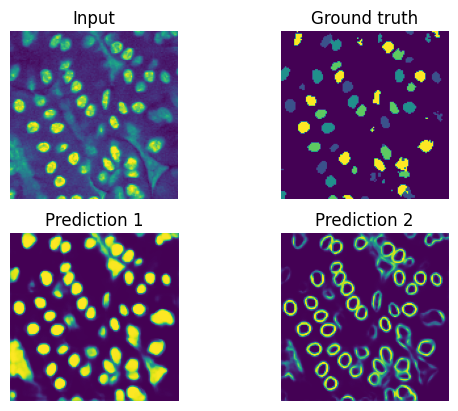

In [28]:
ax1 = plt.subplot(2, 2, 1)
ax1.set_title("Input")
ax1.axis("off")
plt.imshow(image_array2[0, 0, :, :])

ax1 = plt.subplot(2, 2, 2)
ax1.set_title("Ground truth")
ax1.axis("off")
plt.imshow(annotation_array2[ 0, 0, :, :])

ax2 = plt.subplot(2, 2, 3)
ax2.set_title("Prediction 1")
ax2.axis("off")
plt.imshow(pred_array2[0, 0, :, :])

ax2 = plt.subplot(2, 2, 4)
ax2.set_title("Prediction 2")
ax2.axis("off")
plt.imshow(pred_array2[0, 1, :, :])

We will binarise the prediction and the ground truth so we can compare the segmentation results

In [23]:
binary_pred = pred_array2[0, 0, :, :] >= 0.5
annotation_array = np.asarray(annotation_array2)
binary_gt = annotation_array.astype(bool)

In [27]:
scores_image2 = benchmarking_scores(binary_pred, binary_gt)

Precision score: 0.541
Recall score: 0.969


The precision metric for the second image (0.541) is much lower than for the first one (0.972). This makes sense as visually we can see that the model is returning a large number of false positives for the second image. The "affable-shark" model is more suitable to segment the first dataset than the second one.